<a href="https://colab.research.google.com/github/leticiasdrummond/Modelos-Base/blob/main/1_CASO_BASE_ELETROPOSTO_11_02_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pré-básico
Para utilizar o gurobi e o pymo, executar abaixo:

In [1]:

# Instalação limpa (apenas o necessário para CBC)
!pip install -q pyomo
!apt-get install -y -qq coinor-cbc

import pyomo.environ as pyo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



Selecting previously unselected package coinor-libcoinutils3v5:amd64.
(Reading database ... 117540 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-2_amd64.deb ...
Unpacking coinor-libcoinutils3v5:amd64 (2.11.4+repack1-2) ...
Selecting previously unselected package coinor-libosi1v5:amd64.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-2_amd64.deb ...
Unpacking coinor-libosi1v5:amd64 (0.108.6+repack1-2) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unselected package coinor-libcgl1:amd64.
Preparing to unpack .../3-coinor-libcgl1_0.60.3+repack1-3_amd64.deb ...
Unpacking coinor-libcgl1:amd64 (0.60.3+repack1-3) ...
Selecting previously unselected package coinor-libcbc3:amd64.
Preparing to unpack .../4-coinor-libcbc3_2.10.7+ds1-1_amd64.deb ...
Unpacking coinor-libcbc3:


# MODELO 4 – OTIMIZAÇÃO DE BESS EM COMÉRCIO COM ELETROPOSTO
## MILP – Pyomo – Pronto para Google Colab

Curvas de demanda do comércio e eletroposto (separados) criados com dados exemplificados para 24 horas, bem como a curva de geração FV para o mesmo período. Os dados de capacidade e eficiencia da bateria também são fornecidos. A tarifa de compra e venda de energia também são dadas.


In [2]:
# =========================================================
# 1. DADOS DE ENTRADA (EXEMPLO FACTÍVEL)
# =========================================================

T = range(24) # horizonte horário

# Demanda do comércio (kWh)
demanda_comercio = [
    6, 6, 6, 6, 7, 8, 10, 12, 14, 15, 16, 17,
    18, 18, 17, 16, 15, 14, 12, 10, 9, 8, 7, 6
]

# Demanda do eletroposto (kWh)
demanda_ev = [
    0, 0, 0, 0, 0, 0,
    5, 8, 10, 6, 4, 2,
    0, 0, 0, 2, 4, 6,
    8, 6, 4, 2, 0, 0
]

# Geração fotovoltaica (kWh)
geracao_pv = [
    0, 0, 0, 0, 0, 0,
    2, 5, 8, 12, 15, 18,
    20, 18, 15, 10, 6, 3,
    1, 0, 0, 0, 0, 0
]

# Custos (R$/kWh)
custo_compra = 0.75
preco_venda = 0.40

# Parâmetros da bateria
capacidade_bess = 50.0      # kWh
potencia_max_bess = 15.0    # kW
soc_min = 0.20 * capacidade_bess
soc_max = 0.95 * capacidade_bess
soc_inicial = 0.50 * capacidade_bess


eta_c = 0.955  # eficiência de carga
eta_d = 0.955  # eficiência de descarga

# Custo de degradação (R$/kWh throughput)
custo_degradacao = 0.08

In [3]:
# =========================================================
# 2. CRIAÇÃO DO MODELO
# =========================================================

model = pyo.ConcreteModel()

model.T = pyo.Set(initialize=T)

# =========================================================
# 3. VARIÁVEIS DE DECISÃO
# =========================================================

model.P_grid = pyo.Var(model.T, domain=pyo.NonNegativeReals)        # compra da rede
model.P_export = pyo.Var(model.T, domain=pyo.NonNegativeReals)      # venda à rede

model.P_charge = pyo.Var(model.T, domain=pyo.NonNegativeReals)      # carga da bateria
model.P_discharge = pyo.Var(model.T, domain=pyo.NonNegativeReals)  # descarga da bateria

model.SOC = pyo.Var(model.T, domain=pyo.NonNegativeReals)

# Variáveis binárias (bloqueio simultâneo)
model.u_charge = pyo.Var(model.T, domain=pyo.Binary)
model.u_discharge = pyo.Var(model.T, domain=pyo.Binary)

# =========================================================
# 4. FUNÇÃO OBJETIVO
# =========================================================

def objective_rule(m):
    custo_energia = sum(custo_compra * m.P_grid[t] for t in m.T)
    receita_venda = sum(preco_venda * m.P_export[t] for t in m.T)
    custo_deg = sum(
        custo_degradacao * (m.P_charge[t] + m.P_discharge[t])
        for t in m.T
    )
    return custo_energia + custo_deg - receita_venda

model.OBJ = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# =========================================================
# 5. RESTRIÇÕES
# =========================================================

# 5.1 Balanço de energia
def energy_balance_rule(m, t):
    demanda_total = demanda_comercio[t] + demanda_ev[t]
    return (
        m.P_grid[t]
        + geracao_pv[t]
        + m.P_discharge[t]
        ==
        demanda_total
        + m.P_charge[t]
        + m.P_export[t]
    )

model.energy_balance = pyo.Constraint(model.T, rule=energy_balance_rule)
'''
# 5.2 Dinâmica do SOC
def soc_rule(m, t):
    if t == 0:
        return m.SOC[t] == soc_inicial + eta_c * m.P_charge[t] - (1/eta_d) * m.P_discharge[t]
    return m.SOC[t] == m.SOC[t-1] + eta_c * m.P_charge[t] - (1/eta_d) * m.P_discharge[t]

model.soc_dyn = pyo.Constraint(model.T, rule=soc_rule)
'''

# Implementação da Restrição 4.2: Dinâmica do SOC, com perdas explicitadas
def soc_rule(m, t):
    # Losses associated with charging
    charge_losses_kW = (1 - eta_c) * m.P_charge[t]
    # Losses associated with discharging
    # Power drawn from storage is P_discharge / eta_d
    # So discharge losses are (P_discharge / eta_d) - P_discharge
    discharge_losses_kW = (1/eta_d - 1) * m.P_discharge[t]

    # Net change in SOC = (Energy_Charged_Gross - Charge_Losses) - (Energy_Discharged_Gross + Discharge_Losses)
    # This is equivalent to: (eta_c * P_charge) - (P_discharge / eta_d)

    if t == 0:
        # SOC[t] = soc_inicial + RECARGA_BRUTA - PERDAS_CARGA - (DESCARGA_BRUTA + PERDAS_DESCARGA)
        return m.SOC[t] == soc_inicial + (m.P_charge[t] - charge_losses_kW) - (m.P_discharge[t] + discharge_losses_kW)

    # SOC[t] = SOC[t-1] + RECARGA_BRUTA - PERDAS_CARGA - (DESCARGA_BRUTA + PERDAS_DESCARGA)
    return m.SOC[t] == m.SOC[t-1] + (m.P_charge[t] - charge_losses_kW) - (m.P_discharge[t] + discharge_losses_kW)

# Reatribuindo (ou criando, se não existisse) a restrição soc_dyn no modelo
# O Pyomo pode emitir um WARNING se a restrição já existir, indicando que ela está sendo substituída.
model.soc_dyn = pyo.Constraint(model.T, rule=soc_rule)
# 5.3 Limites de SOC
model.soc_min = pyo.Constraint(model.T, rule=lambda m, t: m.SOC[t] >= soc_min)
model.soc_max = pyo.Constraint(model.T, rule=lambda m, t: m.SOC[t] <= soc_max)
#-------------------------------------------------------
# Alteração do código criado no para casa com a revisão do Guilherme
# --------------------------------------------------------
model.soc_amanha = pyo.Constraint(expr= model.SOC[23] >= soc_inicial) #incluido junto do Guilherme para garantir que o BESS esteja minimamente carregado no final das 24h
# -----------------------------------------------------------
# Continua versao do para casa antes do Guilherme
# 5.4 Limites de potência com binárias
model.charge_limit = pyo.Constraint(
    model.T, rule=lambda m, t: m.P_charge[t] <= potencia_max_bess * m.u_charge[t]
)

model.discharge_limit = pyo.Constraint(
    model.T, rule=lambda m, t: m.P_discharge[t] <= potencia_max_bess * m.u_discharge[t]
)

# 5.5 Bloqueio de carga e descarga simultâneas
model.no_simultaneous = pyo.Constraint(
    model.T, rule=lambda m, t: m.u_charge[t] + m.u_discharge[t] <= 1
)



# =========================================================
# 6. RESOLUÇÃO
# =========================================================

solver = pyo.SolverFactory("cbc")
results = solver.solve(model, tee=False)

# =========================================================
# 7. RESULTADOS
# =========================================================

# Define column names explicitly to avoid hidden character issues
col_demanda_comercio = "Demanda_Comercio".strip()
col_demanda_ev = "Demanda_EV".strip()
col_pv = "PV".strip()
col_grid = "Grid".strip()
col_export = "Export".strip()
col_carga_bess = "Carga_BESS".strip()
col_descarga_bess = "Descarga_BESS".strip()
col_soc = "SOC".strip()
col_hora = "Hora".strip()

df = pd.DataFrame({
    col_hora: list(T),
    col_demanda_comercio: demanda_comercio,
    col_demanda_ev: demanda_ev,
    col_pv: geracao_pv,
    col_grid: [pyo.value(model.P_grid[t]) for t in T],
    col_export: [pyo.value(model.P_export[t]) for t in T],
    col_carga_bess: [pyo.value(model.P_charge[t]) for t in T],
    col_descarga_bess: [pyo.value(model.P_discharge[t]) for t in T],
    col_soc: [pyo.value(model.SOC[t]) for t in T]
})

print(df)
print("Custo total (R$):", pyo.value(model.OBJ))

print(f"Valor da Função Objetivo (Custo Total): R$ {pyo.value(model.OBJ):.2f}")

    Hora  Demanda_Comercio  Demanda_EV  PV      Grid  Export  Carga_BESS  \
0      0                 6           0   0   4.17595     0.0         0.0   
1      1                 6           0   0   6.00000     0.0         0.0   
2      2                 6           0   0   6.00000     0.0         0.0   
3      3                 6           0   0   6.00000     0.0         0.0   
4      4                 7           0   0   7.00000     0.0         0.0   
5      5                 8           0   0   8.00000     0.0         0.0   
6      6                10           5   2  13.00000     0.0         0.0   
7      7                12           8   5  15.00000     0.0         0.0   
8      8                14          10   8  16.00000     0.0         0.0   
9      9                15           6  12   9.00000     0.0         0.0   
10    10                16           4  15   5.00000     0.0         0.0   
11    11                17           2  18   1.00000     0.0         0.0   
12    12    

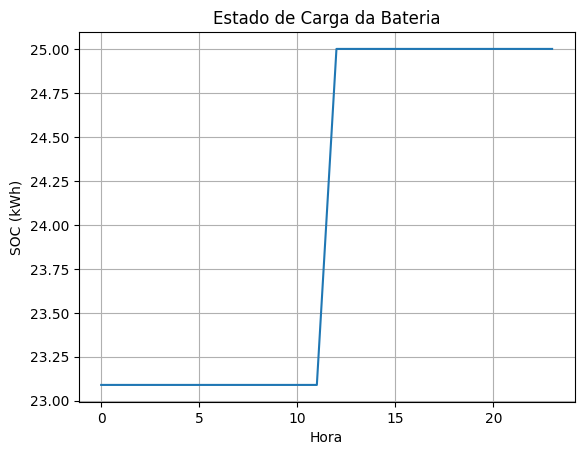

In [4]:

# =========================================================
# 8. GRÁFICOS
# =========================================================

plt.figure()
plt.plot(df[col_hora], df[col_soc])
plt.xlabel("Hora")
plt.ylabel("SOC (kWh)")
plt.title("Estado de Carga da Bateria")
plt.grid()
plt.show()

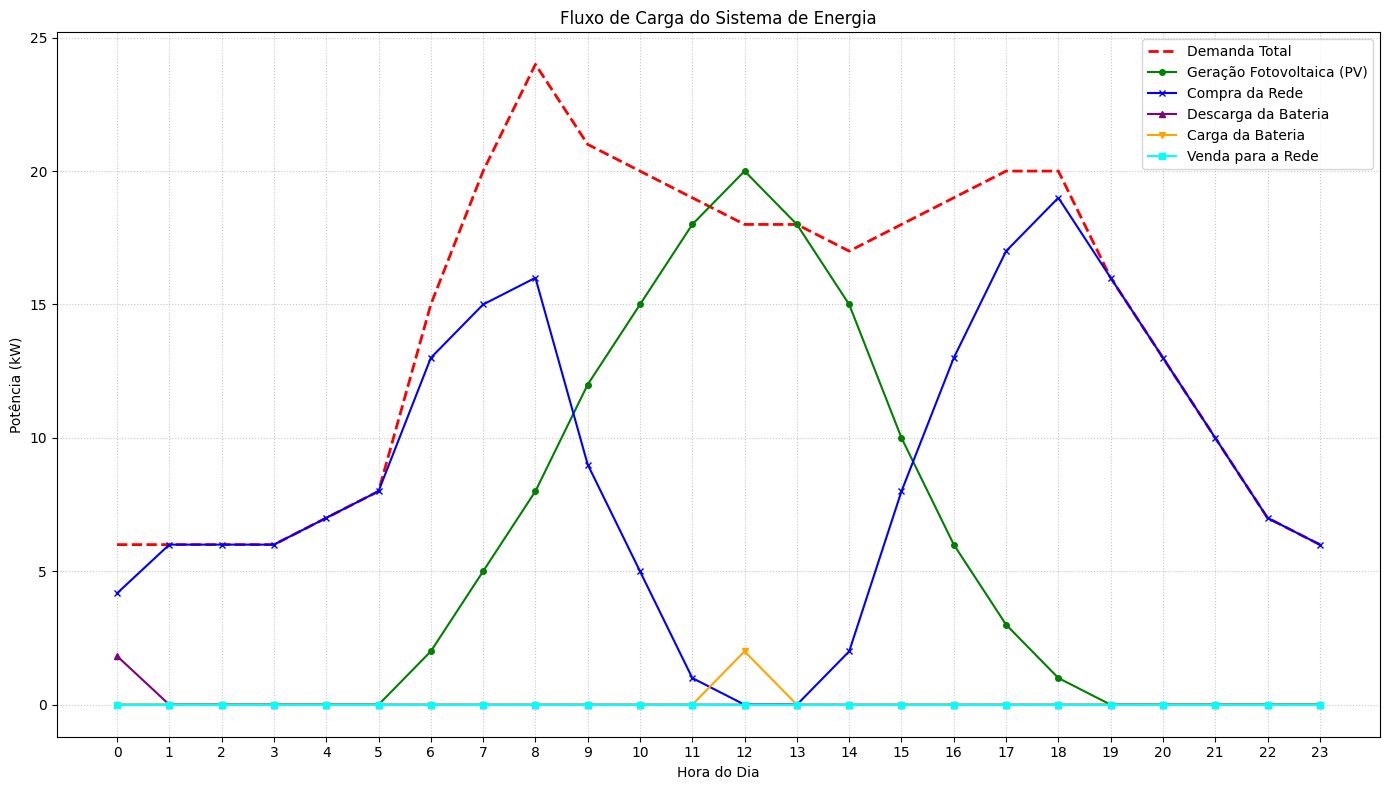

In [5]:
# Define column names explicitly to avoid hidden character issues
col_demanda_comercio = "Demanda_Comercio".strip()
col_demanda_ev = "Demanda_EV".strip()
col_pv = "PV".strip()
col_grid = "Grid".strip()
col_export = "Export".strip()
col_carga_bess = "Carga_BESS".strip()
col_descarga_bess = "Descarga_BESS".strip()
col_soc = "SOC".strip()
col_hora = "Hora".strip()

plt.figure(figsize=(14, 8))

# Plotando a demanda total
df['Demanda_Total'] = df[col_demanda_comercio] + df[col_demanda_ev]
plt.plot(df[col_hora], df['Demanda_Total'], label='Demanda Total', color='red', linestyle='--', linewidth=2)

# Plotando as fontes de energia
plt.plot(df[col_hora], df[col_pv], label='Geração Fotovoltaica (PV)', color='green', marker='o', markersize=4)
plt.plot(df[col_hora], df[col_grid], label='Compra da Rede', color='blue', marker='x', markersize=4)
plt.plot(df[col_hora], df[col_descarga_bess], label='Descarga da Bateria', color='purple', marker='^', markersize=4)
plt.plot(df[col_hora], df[col_carga_bess], label='Carga da Bateria', color='orange', marker='v', markersize=4)
plt.plot(df[col_hora], df[col_export], label='Venda para a Rede', color='cyan', marker='s', markersize=4)

plt.xlabel('Hora do Dia')
plt.ylabel('Potência (kW)')
plt.title('Fluxo de Carga do Sistema de Energia')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(df[col_hora])
plt.tight_layout()
plt.show()

Este gráfico mostra os fluxos de potência de cada componente do sistema ao longo das 24 horas. Você pode observar:

*   **Demanda Total (linha vermelha tracejada)**: A soma da demanda do comércio e do eletroposto.
*   **Geração Fotovoltaica (linha verde)**: A produção de energia solar, que é maior durante o dia.
*   **Compra da Rede (linha azul)**: A energia que o sistema precisa comprar da concessionária para cobrir o déficit.
*   **Descarga da Bateria (linha roxa)**: Quando a bateria está fornecendo energia para o sistema.
*   **Carga da Bateria (linha laranja)**: Quando a bateria está sendo carregada.
*   **Venda para a Rede (linha ciano)**: Excedente de energia sendo exportado para a rede.

Com este gráfico, é possível analisar o balanço energético do sistema, como a bateria e a geração fotovoltaica atuam para suprir a demanda e interagem com a rede elétrica.